In [1]:
import os
print os.getcwd()

/Users/weidian1/Documents/GitHub/Udacity-DAND/P5-Intro to ML/Project5/final_project


In [1]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")
#sys.path.append("../pylof-master/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
#features_list = ['poi','salary',''] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 数据探索

In [2]:
# 异常值， 去掉total
def remove_outerliers(data_dict,names):
    for name in names:
        data_dict.pop(name, 0)
    return data_dict

def dateset_summary(data_dic):
    n_poi,n_non_poi = 0,0
    for key in data_dict.keys():
        if data_dict[key]['poi']==1:
            n_poi+=1
        else:
            n_non_poi+=1        
    print "Total number of data points: ", len(data_dict)
    print "Number of POI: %d, no. of non-POI: %d"% (n_poi, n_non_poi)
    print "Number of features used: ",len(data_dict['METTS MARK']) # randomly pick one name, get the number of features.

outliers_names = ['TOTAL']#,'LAVORATO JOHN J'

data_dict = remove_outerliers(data_dict,outliers_names)
dateset_summary(dateset_summary)

Total number of data points:  145
Number of POI: 18, no. of non-POI: 127
Number of features used:  21


In [108]:
print data_df[email_fatures].apply(NaNs_to_None, axis=0).describe()

        to_messages  from_poi_to_this_person  from_messages  \
count     86.000000                86.000000      86.000000   
mean    2073.860465                64.895349     608.790698   
std     2582.700981                86.979244    1841.033949   
min       57.000000                 0.000000      12.000000   
25%      541.250000                10.000000      22.750000   
50%     1211.000000                35.000000      41.000000   
75%     2634.750000                72.250000     145.500000   
max    15149.000000               528.000000   14368.000000   

       from_this_person_to_poi  shared_receipt_with_poi  
count                86.000000                86.000000  
mean                 41.232558              1176.465116  
std                 100.073111              1178.317641  
min                   0.000000                 2.000000  
25%                   1.000000               249.750000  
50%                   8.000000               740.500000  
75%                  24.75

In [3]:
import pandas as pd
import numpy as np

data_df = pd.DataFrame.from_dict(data_dict,orient='index')

financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus'
                 , 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses'
                 , 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock'
                 , 'director_fees']
email_fatures = ['to_messages','from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi'
                 , 'shared_receipt_with_poi']  # remove 'email_address'
def NaNs_to_0s(col):
    return [0 if ele=='NaN' else ele for ele in col]

def NaNs_to_None(col):
    return [None if ele=='NaN' else ele for ele in col]

def count_NAN(col):
    return sum(1 for ele in col if ele == 'NaN')

data_df[financial_features] = data_df[financial_features].apply(NaNs_to_0s, axis=0)
data_df['poi'] = data_df['poi'].astype(int)
print data_df.apply(count_NAN, axis=0)   

salary                        0
to_messages                  59
deferral_payments             0
total_payments                0
exercised_stock_options       0
bonus                         0
restricted_stock              0
shared_receipt_with_poi      59
restricted_stock_deferred     0
total_stock_value             0
expenses                      0
loan_advances                 0
from_messages                59
other                         0
from_this_person_to_poi      59
poi                           0
director_fees                 0
deferred_income               0
long_term_incentive           0
email_address                34
from_poi_to_this_person      59
dtype: int64


## plot

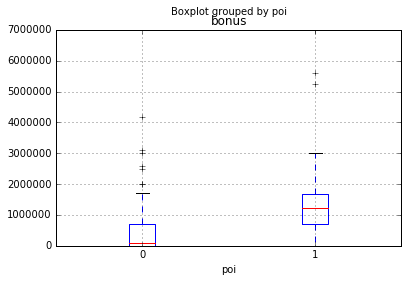

In [154]:
%matplotlib inline
data_df.boxplot('bonus', by='poi')

## add new features

In [4]:
"""
make new feature 
1. 'email_features_miss': if email_features is missing. next step, missing email_features will be
transformed to 0, which should by different from missing financial features.   
2. poi_rate_to_messages = from_this_person_to_poi/to_messages  
3. poi_rate_from_messages = from_poi_to_this_person/from_messages

"""
data_df['email_features_miss'] = data_df.apply(lambda x: 1 if x["to_messages"]=='NaN' else 0, axis = 1)

data_df['poi_rate_to_messages'] = data_df.apply(lambda x: 0 if x['from_this_person_to_poi']=='NaN' \
                                                else x['from_this_person_to_poi']*1.0/x['to_messages'], axis=1)

data_df['poi_rate_from_messages'] = data_df.apply(lambda x: 0 if x['from_poi_to_this_person']=='NaN'\
                                                  else x['from_poi_to_this_person']*1.0/x['from_messages'], axis =1)



    

In [156]:
"""create new features
"""
def get_new(col,p):
    return (data_df[col].apply(abs)/(10**(p-1))%10).astype(int)
def over_zero(ele):
    if ele>0:
        return 1
    return 0

def add_new_features(df):
    df["bonus_over_zero"] = df['bonus'].apply(over_zero)
    df["bonus_six"] = get_new("bonus",6)
    df["bonus_seven"] = get_new("bonus",7)
    
    df["expenses_over_zero"] = df["expenses"].apply(over_zero)
    df["expenses_five"] = get_new("expenses",5)
    df["expenses_six"] = get_new("expenses",6)
    
    df["exercised_stock_options_over_zero"] = df["exercised_stock_options"].apply(over_zero)
    df["exercised_stock_options_six"] = get_new("exercised_stock_options",6)
    df["exercised_stock_options_seven"] = get_new("exercised_stock_options",7)
    df["exercised_stock_options_eight"] = get_new("exercised_stock_options",8)
    
    df["salary_over_zero"] = df["salary"].apply(over_zero)
    df["salary_six"] = get_new("salary",6)
    df["salary_seven"] = get_new("salary",7)
    
    df["restricted_stock_over_zero"] = df["restricted_stock"].apply(over_zero)
    df["restricted_stock_six"] = get_new("restricted_stock",6)
    df["restricted_stock_seven"] = get_new("restricted_stock",7)
    df["restricted_stock_eight"] = get_new("restricted_stock",8)
    
    df["deferred_income_over_zero"] = df["deferred_income"].apply(over_zero)
    df["deferred_income_five"] = get_new("deferred_income",5)
    df["deferred_income_six"] = get_new("deferred_income",6)
    df["deferred_income_seven"] = get_new("deferred_income",7)
    
    df["other_over_zero"] = df["other"].apply(over_zero)
    df["other_six"] = get_new("other",6)
    df["other_seven"] = get_new("other",7)
    df["other_eight"] = get_new("other",8)
    return df

data_df = add_new_features(data_df)

## get mydata(dic)

In [5]:
features_full_list = list(data_df.columns.values)
features_full_list.remove('email_address')
features_full_list.remove('poi')
features_full_list = ['poi'] +features_full_list
data_full_dic = data_df.to_dict(orient='index')


def get_train_test_dataset(my_dataset,features_list):
    #Extract features and labels from dataset for local testing
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    # TODO: Shuffle the data
    from sklearn.utils import shuffle
    features, labels = shuffle(features, labels, random_state=1)
    
    # split train test dataset
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = get_train_test_dataset(data_full_dic,features_full_list)  
    
    

In [6]:
y_test

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

## scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

## select features

In [8]:
"""
select important features 
"""
def select_features(X_train,y_train,X_test, method='tree',k=None):
    from sklearn.utils import shuffle
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    if method == 'tree':
        
        from sklearn.ensemble import ExtraTreesClassifier
        from sklearn.feature_selection import SelectFromModel   

        selection_tree = ExtraTreesClassifier(random_state=32)
        selection_tree = selection_tree.fit(X_train, y_train)

        model_tree = SelectFromModel(selection_tree, prefit=True)
        X_train_new = model_tree.transform(X_train)
        X_test_new = model_tree.transform(X_test)
        
        print "shape of X_train: ", X_train.shape
        print "shape of X_train_new: ", X_train_new.shape    
        return selection_tree,X_train_new,X_test_new
    
    elif method == 'kbest' and k:
        from sklearn.feature_selection import SelectKBest
        from sklearn.feature_selection import f_classif

        selection_k= SelectKBest(f_classif, k=k).fit(X_train, y_train)
        X_train_new = selection_k.transform(X_train)
        X_test_new = selection_k.transform(X_test)
        print "shape of X_train: ", X_train.shape
        print "shape of X_train_new: ", X_train_new.shape   
        return selection_k,X_train_new,X_test_new
        
    




In [11]:
#selection_tree,X_train_new,X_test_new = select_features(X_train_scaled,y_train,X_test_scaled)
X_train_new,X_test_new = X_train_scaled,X_test_scaled

In [10]:
selection_k,X_train_new,X_test_new = select_features(X_train_scaled,y_train,X_test_scaled,method='kbest',k=10)

shape of X_train:  (101, 22)
shape of X_train_new:  (101, 10)


## train algorithm

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
def train_model(classifier,features_train,labels_train,features_test):
    clf = classifier
    clf.fit(features_train, labels_train)
    labels_pred = clf.predict(features_test)
    return clf,labels_pred

## evaluation metrics

In [13]:
def evaluation_metric(labels_test,labels_pred):
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import f1_score
    
    print "recall_score: ",recall_score(y_test, labels_pred)
    print "precision_score: ",precision_score(labels_test, labels_pred)  
    print "f1_score: ",f1_score(labels_test, labels_pred)  
  

### 用tree 的到的features，建模，问题
navie bayers 和 decision tree 完全反的;    
SVM，randomforest 出现no TP

In [14]:
# naive bayers
clf_nb,y_pred_nb = train_model(GaussianNB(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_nb)

recall_score:  0.666666666667
precision_score:  0.285714285714
f1_score:  0.4


In [15]:
#svm
clf_svm,y_pred_svm = train_model(SVC(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_svm)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/weidian1/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
# decision tree
clf_dtree,y_pred_stree = train_model(tree.DecisionTreeClassifier(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_stree)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


In [214]:
# random forest

clf_froest,y_pred_forest = train_model(RandomForestClassifier(n_estimators=10),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_forest)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


## Kbest 

In [215]:
# naive bayers
clf_nb,y_pred_nb = train_model(GaussianNB(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_nb)

recall_score:  0.666666666667
precision_score:  0.285714285714
f1_score:  0.4


In [216]:
#svm
clf_svm,y_pred_svm = train_model(SVC(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_svm)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


In [217]:
# decision tree
clf_dtree,y_pred_stree = train_model(tree.DecisionTreeClassifier(),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_stree)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


In [218]:
# random forest

clf_froest,y_pred_forest = train_model(RandomForestClassifier(n_estimators=10),X_train_new,y_train,X_test_new)
evaluation_metric(y_test,y_pred_forest)

recall_score:  0.0
precision_score:  0.0
f1_score:  0.0


## Pipiline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe 


In [ ]:
pipe.steps[0]
pipe.named_steps['reduce_dim']
pipe.set_params(clf__C=10) 

In [ ]:
from sklearn.model_selection import GridSearchCV
params = dict(reduce_dim__n_components=[2, 5, 10],
              clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=params)

In [ ]:
from sklearn.linear_model import LogisticRegression
params = dict(reduce_dim=[None, PCA(5), PCA(10)],
              clf=[SVC(), LogisticRegression()],
              clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=params)

In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel  
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
model_tree = SelectFromModel(ExtraTreesClassifier(random_state=32), prefit=True)
clf = GaussianNB()
        
estimators = [('scaler',min_max_scaler)
              ,('selector',model_tree)
              ,('clf',clf)]
pipe= Pipeline(estimators)

params = dict(reduce_dim__n_components=[2, 5, 10],
              clf__C=[0.1, 10, 100])
grid_search = GridSearchCV(pipe, param_grid=params)

In [263]:
dict(reduce_dim__n_components=[2, 5, 10],
              clf__C=[0.1, 10, 100])

{'clf__C': [0.1, 10, 100], 'reduce_dim__n_components': [2, 5, 10]}

In [260]:
import pandas as pd
from numpy import mean,std
from sklearn.grid_search import GridSearchCV

class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': mean(scores),
                 'std_score': std(scores),
            }
            return pd.Series(dict(params.items() + d.items()))

        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values(by=[sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [20]:
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

models1 = { 
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC()
}

params1 = { 
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}

In [261]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train_new,y_train,cv=3, scoring='f1', n_jobs=-1)

Running GridSearchCV for SVC.
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.2s finished


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished


Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished


In [262]:
helper1.score_summary(sort_by='mean_score')

,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,learning_rate,n_estimators
7,AdaBoostClassifier,0.4,0.733333,1,0.249444,NaN,NaN,NaN,NaN,32
8,GradientBoostingClassifier,0.4,0.546032,0.666667,0.110337,NaN,NaN,NaN,0.8,16
11,GradientBoostingClassifier,0.4,0.546032,0.666667,0.110337,NaN,NaN,NaN,1,32
9,GradientBoostingClassifier,0.4,0.457143,0.571429,0.0808122,NaN,NaN,NaN,0.8,32
10,GradientBoostingClassifier,0.333333,0.434921,0.571429,0.100289,NaN,NaN,NaN,1,16
1,SVC,0,0.433333,0.8,0.329983,10,NaN,linear,NaN,NaN
6,AdaBoostClassifier,0,0.433333,0.8,0.329983,NaN,NaN,NaN,NaN,16
13,ExtraTreesClassifier,0,0.433333,0.8,0.329983,NaN,NaN,NaN,NaN,32
0,SVC,0,0.166667,0.5,0.235702,1,NaN,linear,NaN,NaN
12,ExtraTreesClassifier,0,0.166667,0.5,0.235702,NaN,NaN,NaN,NaN,16


In [ ]:
  def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': mean(scores),
                 'std_score': std(scores),
            }
            return pd.Series(dict(params.items() + d.items()))

        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns]

In [232]:
helper1.grid_searches['AdaBoostClassifier']

GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [16, 32]}, pre_dispatch='2*n_jobs',
       refit=False, scoring='f1', verbose=1)

In [247]:
helper1.grid_searches['AdaBoostClassifier'].grid_scores_[0].parameters.items()+d.items()


[('n_estimators', 16),
 ('std_score', 0.2),
 ('min_score', 0.3),
 ('estimator', 'AdaBoostClassifier'),
 ('max_score', 0.8),
 ('mean_score', 0.44)]

In [268]:
helper1.grid_searches['AdaBoostClassifier'].grid_scores_

[mean: 0.42970, std: 0.32998, params: {'n_estimators': 16},
 mean: 0.73267, std: 0.24944, params: {'n_estimators': 32}]

In [267]:
helper1.grid_searches['AdaBoostClassifier'].grid_scores_[0].parameters.items()

[('n_estimators', 16)]

In [264]:
d.items()

[('std_score', 0.2),
 ('min_score', 0.3),
 ('estimator', 'AdaBoostClassifier'),
 ('max_score', 0.8),
 ('mean_score', 0.44)]

In [244]:
            d = {
                 'estimator': 'AdaBoostClassifier',
                 'min_score': 0.3,
                 'max_score': 0.8,
                 'mean_score': 0.44,
                 'std_score': 0.2,
            }

In [245]:
d.items()+

[('std_score', 0.2),
 ('min_score', 0.3),
 ('estimator', 'AdaBoostClassifier'),
 ('max_score', 0.8),
 ('mean_score', 0.44)]

In [239]:
helper1.grid_searches['AdaBoostClassifier'].grid_scores_

[mean: 0.42970, std: 0.32998, params: {'n_estimators': 16},
 mean: 0.73267, std: 0.24944, params: {'n_estimators': 32}]

In [248]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(iris.data, iris.target)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [249]:
clf.cv_results_

{'mean_fit_time': array([ 0.00063491,  0.00046666,  0.00044266,  0.00074569]),
 'mean_score_time': array([ 0.00031439,  0.00036033,  0.00029103,  0.00052603]),
 'mean_test_score': array([ 0.98      ,  0.97333333,  0.97333333,  0.98      ]),
 'mean_train_score': array([ 0.98999802,  0.98336304,  0.97999604,  0.97999604]),
 'param_C': masked_array(data = [1 1 10 10],
              mask = [False False False False],
        fill_value = ?),
 'param_kernel': masked_array(data = ['linear' 'rbf' 'linear' 'rbf'],
              mask = [False False False False],
        fill_value = ?),
 'params': ({'C': 1, 'kernel': 'linear'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'}),
 'rank_test_score': array([1, 3, 3, 1], dtype=int32),
 'split0_test_score': array([ 1.        ,  0.98039216,  1.        ,  0.98039216]),
 'split0_train_score': array([ 0.97979798,  0.96969697,  0.95959596,  0.95959596]),
 'split1_test_score': array([ 0.96078431,  0.96078431,  0.92

In [254]:
print clf.scorer_

<function _passthrough_scorer at 0x10aa44410>


In [275]:
d = {
'split0_test_score'  : [0.8, 0.7, 0.8, 0.9],
'split1_test_score'  : [0.82, 0.5, 0.7, 0.78],
'mean_test_score'    : [0.81, 0.60, 0.75, 0.82],
'std_test_score'     : [0.02, 0.01, 0.03, 0.03],
'rank_test_score'    : [2, 4, 3, 1],

'mean_fit_time'      : [0.73, 0.63, 0.43, 0.49],
'std_fit_time'       : [0.01, 0.02, 0.01, 0.01],
'mean_score_time'    : [0.007, 0.06, 0.04, 0.04],
'std_score_time'     : [0.001, 0.002, 0.003, 0.005]}
#'params'             : [{'kernel': 'poly', 'degree': 2}],
#}

d_df = pd.DataFrame.from_dict(d,orient = 'columns')

In [276]:
d_df

,mean_fit_time,mean_score_time,mean_test_score,rank_test_score,split0_test_score,split1_test_score,std_fit_time,std_score_time,std_test_score
0,0.73,0.007,0.81,2,0.8,0.82,0.01,0.001,0.02
1,0.63,0.060,0.60,4,0.7,0.50,0.02,0.002,0.01
2,0.43,0.040,0.75,3,0.8,0.70,0.01,0.003,0.03
3,0.49,0.040,0.82,1,0.9,0.78,0.01,0.005,0.03


In [277]:
d.items()

[('rank_test_score', [2, 4, 3, 1]),
 ('std_score_time', [0.001, 0.002, 0.003, 0.005]),
 ('mean_test_score', [0.81, 0.6, 0.75, 0.82]),
 ('std_test_score', [0.02, 0.01, 0.03, 0.03]),
 ('mean_score_time', [0.007, 0.06, 0.04, 0.04]),
 ('mean_fit_time', [0.73, 0.63, 0.43, 0.49]),
 ('split0_test_score', [0.8, 0.7, 0.8, 0.9]),
 ('split1_test_score', [0.82, 0.5, 0.7, 0.78]),
 ('std_fit_time', [0.01, 0.02, 0.01, 0.01])]

In [278]:
['k']*3


['k', 'k', 'k']

In [281]:
testd_d={}
testd_d['ce'] ='cew'


In [23]:
import pandas as pd
from numpy import mean,std
from sklearn.model_selection import GridSearchCV 
#reload(GridSearchCV)
#from sklearn.grid_search import GridSearchCV

'''
refit : boolean, default=True
Refit the best estimator with the entire dataset. 
If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
'''


class ModelsSelector(object):
	"""docstring for ClassName"""
	def __init__(self, models, params):
		if not set(models.keys()).issubset(set(params.keys())):
			miss_models =  set(models.keys()) - set(params.keys())
			raise ValueError("Some models are missing parameters %s: ." % miss_models)
		self.models = models
		self.params = params
		self.keys = models.keys()
		self.grid_select = {}

	def fit(self, X, y, cv=3, scoring=None, refit=False, verbose=1, n_jobs=1):
		for key in self.keys:
			print ("Running GridSelectCV for %s ." % key)
			model = self.models[key]
			params = self.params[key]
			gs_cv = GridSearchCV(model, param_grid=params, cv=cv, scoring=scoring,
								n_jobs=n_jobs, refit=refit, verbose=verbose)
			gs_cv.fit
			self.grid_select[key] = gs_cv


	def score_summary(self,sort_by='mean_score'):
		evaluate_keys = ['mean_test_score','std_test_score','mean_train_score','std_train_score','params','rank_test_score']
		cv_result_dfs = []
		for k in self.keys:
			cv_result_dict = {}
			for gs_cv_result_k, gs_cv_result_v in self.grid_select[k].cv_results_:
				if gs_cv_result_k in evaluate_keys:
					cv_result_dict['gs_cv_result_k'] = gs_cv_result_v
 			cv_result_dict['estimator'] = [k]*len(cv_results_['mean_test_score'])
 			cv_result_df = pd.DataFrame.from_dict(cv_result_dict,orient='columns')
 			cv_result_dfs.append(cv_result_df)
 #[mydict[x] for x in evaluate_keys]
 		cv_results = pd.concat(cv_result_dfs)
 		return cv_results

In [24]:
helper2 = ModelsSelector(models1, params1)
helper2.fit(X_train_new,y_train,cv=3, scoring='f1', n_jobs=-1)

Running GridSelectCV for SVC .
Running GridSelectCV for AdaBoostClassifier .
Running GridSelectCV for GradientBoostingClassifier .
Running GridSelectCV for ExtraTreesClassifier .
Running GridSelectCV for RandomForestClassifier .


In [25]:
helper2.score_summary(sort_by='mean_score')

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [27]:
import sklearn
sklearn.__version__

'0.18.1'